In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy as sp

In [143]:
d = np.load('data1.npz')
lat = d['lat'];lon = d['lon'];u=d['u']

In [3]:
def plot_field(lat,lon,u,time,levels=20):
    """
    Generate contour plot of u at particular time
    Use if/as needed
    Input:
    lat,lon: latitude and longitude arrays
    u: full array of wind speed data
    time: time at which wind speed will be plotted (index between 0 and 364)
    levels: number of contour levels in plot
    """
    


    plt.figure()
    plt.contourf(lon,lat,u[time,:,:],levels)
    plt.axis('equal')
    plt.grid()
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    
    return None

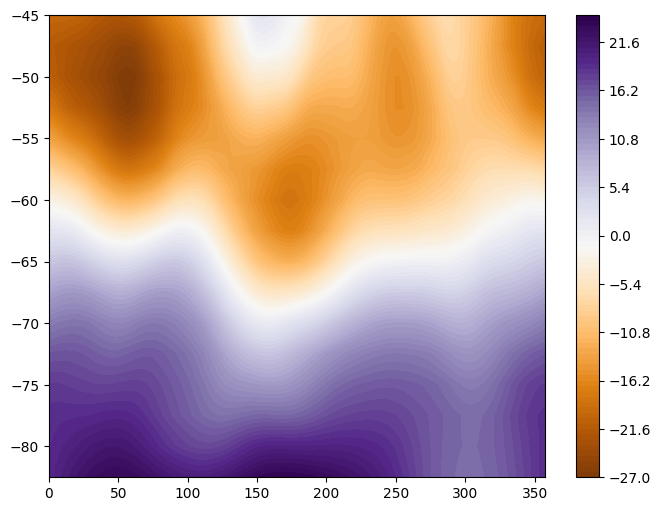

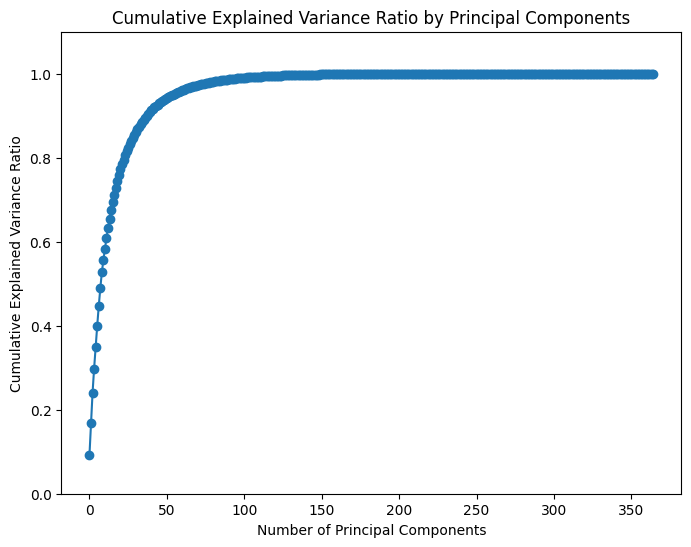

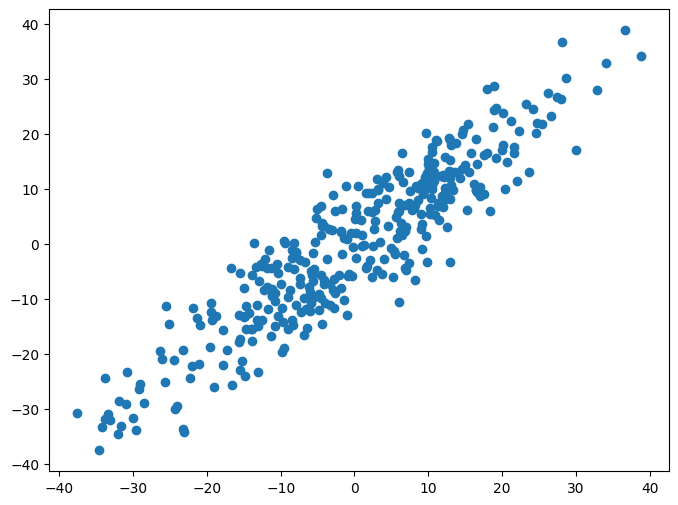

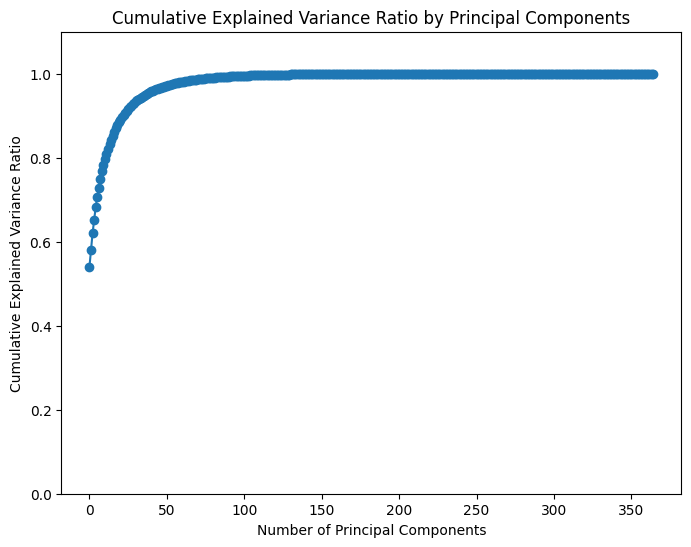

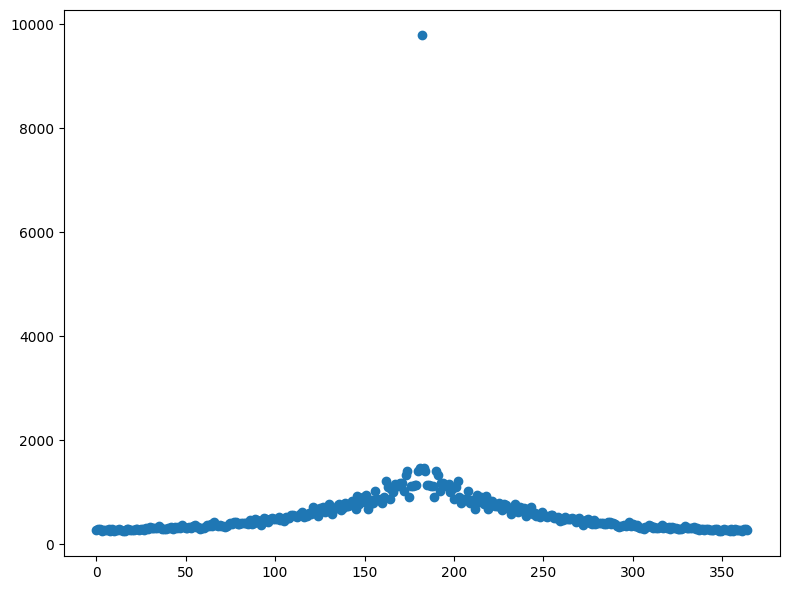

In [645]:
def part1():#add input if needed
    """
    Code for part 1
    """ 

    #--- load data ---#
    d = np.load('data1.npz')
    lat = d['lat'];lon = d['lon'];u=d['u']
    #-------------------------------------#

    #Add code here 
    X1 = u.reshape(365, -1)
    A1 = ((X1 - np.mean(X1, axis = 0))/np.std(X1, axis = 0)).T
    U1, S1, WT1 = np.linalg.svd(A1)
    T1 = U1.T
    Anew1 = np.matmul(T1, A1)
    explained_variance_1 = S1**2 / np.sum(S1**2)
    n = np.argmax(np.cumsum(explained_variance_1) > 0.95)
    Areduced1 = np.matmul(U1[:, n:], Anew1[n:, :])

    X2 = u.reshape(365, -1).T
    A2 = ((X2 - np.mean(X2, axis = 0))/np.std(X2, axis = 0)).T
    U2, S2, WT2 = np.linalg.svd(A2)
    T2 = U2.T
    Anew2 = np.matmul(T2, A2)
    explained_variance_2 = S2**2 / np.sum(S2**2)
    n = np.argmax(np.cumsum(explained_variance_2) > 0.95)
    Areduced2 = np.matmul(U2[:, n:], Anew2[n:, :]).reshape(np.shape(u))
    coefs = np.zeros(365)
    for i in range(16):
        fft_coefs = np.fft.fftshift(np.fft.fft2(u[:, i, :]))
        coefs += np.mean(np.abs(fft_coefs), axis = 1)
    coefs = coefs/16

    plt.figure(figsize = (8, 6))
    plt.contourf(lon, lat, Anew2[0, :].reshape(16, 144), levels=100, cmap = 'PuOr')
    plt.colorbar()

    plt.figure(figsize = (8, 6))
    plt.plot(np.cumsum(explained_variance_1), marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio by Principal Components')
    plt.ylim(0, 1.1)

    plt.figure(figsize = (8, 6))
    plt.scatter(Anew1[0, :][:-1], Anew1[0, :][1:], marker='o')

    plt.figure(figsize = (8, 6))
    plt.plot(np.cumsum(explained_variance_2), marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio by Principal Components')
    plt.ylim(0, 1.1)

    plt.figure(figsize = (8, 6))
    plt.scatter(range(len(coefs)), coefs)
    #plt.colorbar()

    plt.tight_layout()
    plt.show()


    return None #modify if needed
part1()

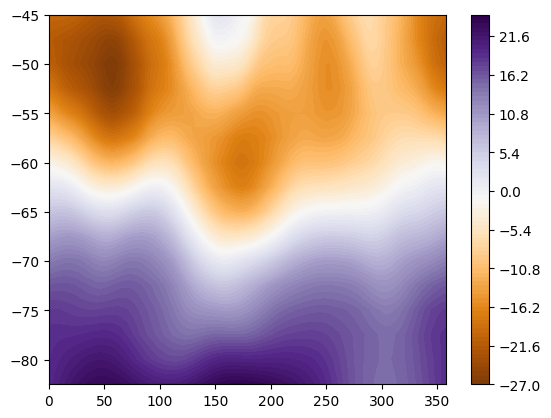

In [469]:
X = u.reshape(365, -1).T
A = ((X - np.mean(X, axis = 0))/np.std(X, axis = 0)).T
U, S, WT = np.linalg.svd(A)
T = U.T
Anew = np.matmul(T, A)
explained_variance = S**2 / np.sum(S**2)
n = np.argmax(np.cumsum(explained_variance) > 0.95)
Areduced = np.matmul(U[:, n:], Anew[n:, :])
plt.contourf(lon, lat, Anew[0, :].reshape(16, 144), levels=100, cmap = 'PuOr')
plt.colorbar()

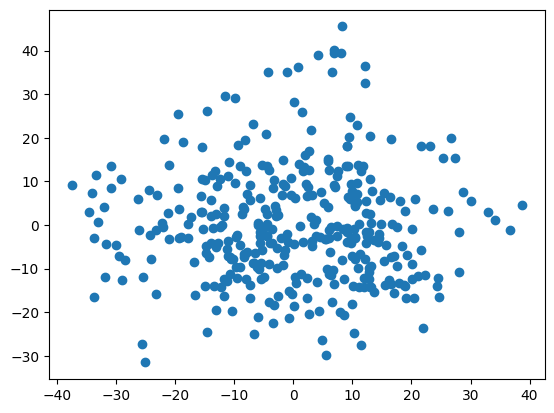

In [355]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA(0.95)
X_std = pca.fit_transform(A.T)
np.shape(X_std)
plt.scatter(X_std[:, 0], X_std[:, 1])

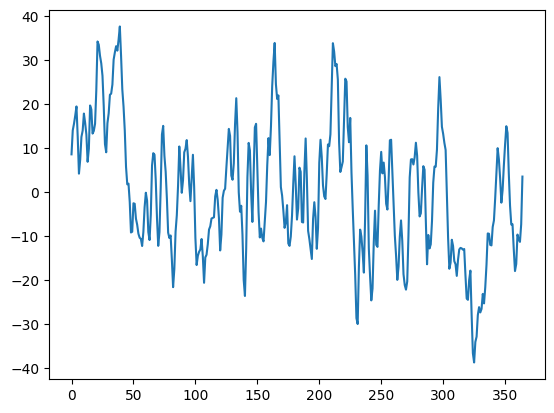

In [329]:
data = A.T
V = np.cov(data)
vals, vecs = np.linalg.eig(V)
P = vecs.T.dot(data)
plt.plot(P[0, :])

In [447]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, fftfreq
import time

def plot_3d_wind_speed_fft(wind_speeds, latitude, longitude, time, time_axis=0, spatial_axes=(1, 2)):
    # Perform 3D Fourier transform
    fft_result = fftn(wind_speeds, axes=(time_axis, spatial_axes[0], spatial_axes[1]))

    # Calculate the frequency values
    sampling_rate_time = 1 / (time[1] - time[0])
    sampling_rate_spatial_x = 1 / (longitude[1] - longitude[0])
    sampling_rate_spatial_y = 1 / (latitude[1] - latitude[0])
    frequencies_time = fftfreq(len(fft_result), d=1/sampling_rate_time)
    frequencies_spatial_x = fftfreq(len(fft_result[0]), d=1/sampling_rate_spatial_x)
    frequencies_spatial_y = fftfreq(len(fft_result[1]), d=1/sampling_rate_spatial_y)

    # Plot the original signal
    plt.figure(figsize=(15, 6))

    plt.subplot(2, 2, 1)
    plt.imshow(wind_speeds.mean(axis=time_axis), extent=(longitude[0], longitude[-1], latitude[0], latitude[-1]))
    plt.title('Mean Wind Speed')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.imshow(wind_speeds.std(axis=time_axis), extent=(longitude[0], longitude[-1], latitude[0], latitude[-1]))
    plt.title('Standard Deviation of Wind Speed')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()

    # Plot the Fourier Transform in the time domain
    plt.subplot(2, 2, 3)
    plt.semilogy(frequencies_time, np.abs(fft_result.mean(axis=(spatial_axes[0], spatial_axes[1]))))
    plt.title('Time Domain: Fourier Transform of Mean Wind Speed')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, sampling_rate_time / 2)

    # Plot the Fourier Transform in the spatial domain
    plt.subplot(2, 2, 4)
    plt.imshow(np.abs(fft_result.mean(axis=time_axis)), extent=(frequencies_spatial_x[0], frequencies_spatial_x[-1], frequencies_spatial_y[0], frequencies_spatial_y[-1]))
    plt.title('Spatial Domain: Fourier Transform of Mean Wind Speed')
    plt.xlabel('Frequency X (Hz)')
    plt.ylabel('Frequency Y (Hz)')
    plt.colorbar()

    plt.tight_layout()
    plt.show()
    return None

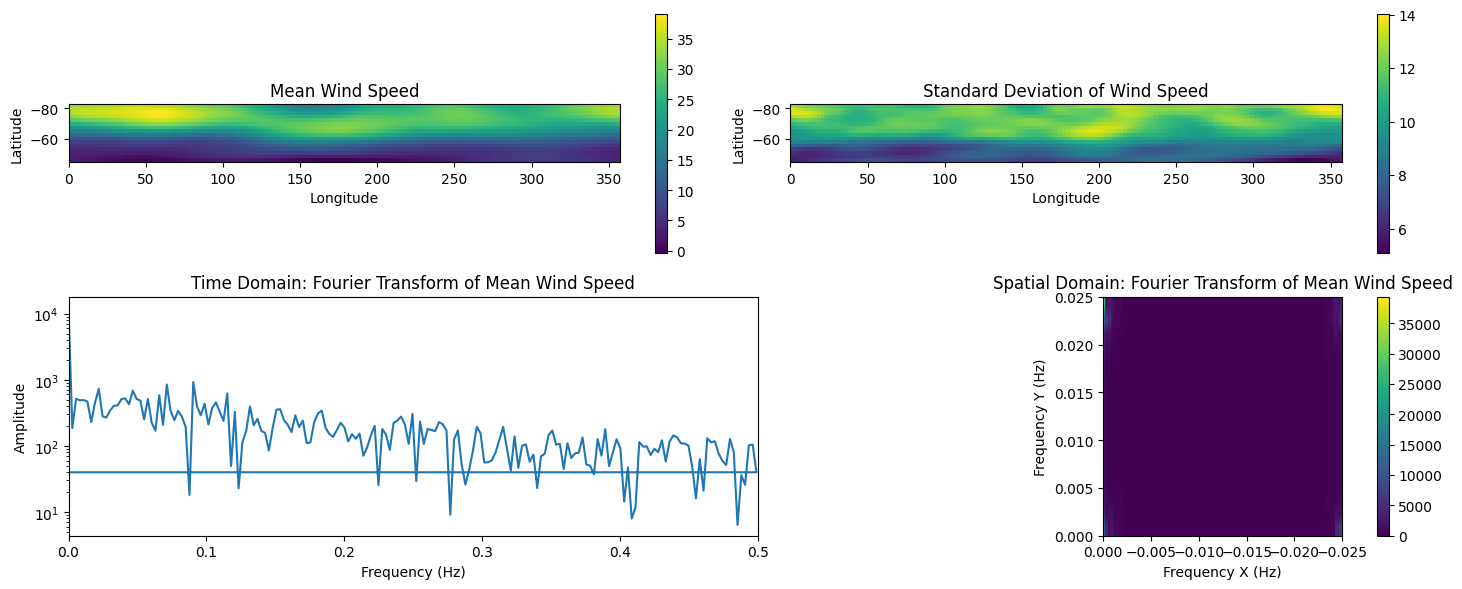

In [448]:
plot_3d_wind_speed_fft(u, lat, lon, np.arange(0, 364, 1))

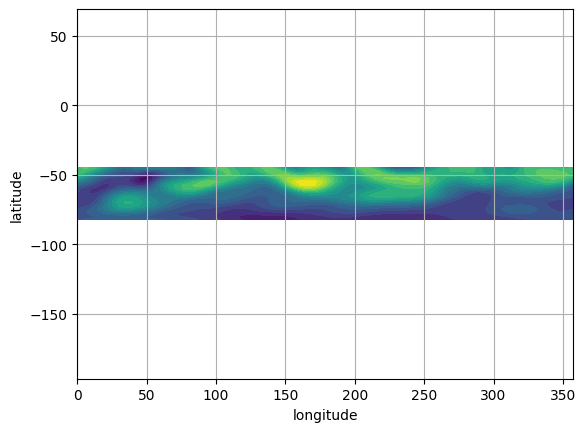

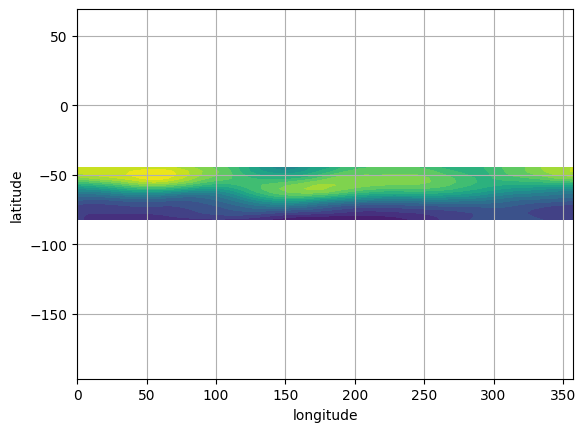

In [240]:
plot_field(lat, lon, u, 0)
plot_field(lat, lon, u_reduced, 0)

In [251]:
F = u.reshape(365, -1)
F_hat = np.fft.fft2(F)
F_hat_reshaped = F_hat.reshape(np.shape(u))
np.shape(F_hat_reshaped[0])

(16, 144)

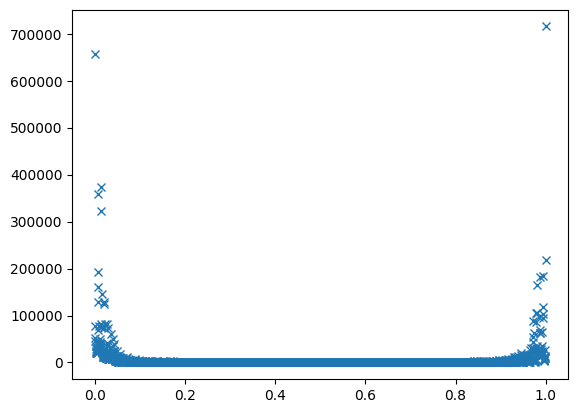

In [259]:
#plot_field(lat, lon, F_hat_reshaped, 150)
plt.plot(np.linspace(0, 1, 16*144), np.abs(F_hat_reshaped[364].reshape(16*144)), 'x')

In [596]:
np.shape(u[np.argmax(np.std(np.reshape(u, (365, )), axis=1))::])

ValueError: cannot reshape array of size 3204000 into shape (365,2304)

In [366]:
def part2(f,method=2):
    """
    Question 2.1 i)
    Input:
        f: m x n array
        method: 1 or 2, interpolation method to use
    Output:
        fI: interpolated data (using method)
    """

    m,n = f.shape
    fI = np.zeros((m-1,n)) #use/modify as needed

    if method==1:
        fI = 0.5*(f[:-1,:]+f[1:,:])
    else:
        #Coefficients for method 2
        alpha = 0.3
        a = 1.5
        b = 0.1
        
        #coefficients for near-boundary points
        a_bc,b_bc,c_bc,d_bc = (5/16,15/16,-5/16,1/16)

        #add code here
        #using linear system representation of interpolation, form LHS and RHS coefficient matrices
        #first make LHS coefficients including adjustments for i = 1/2 and i = m - 3/2
        
        LHS = np.zeros((3, m-1))
        LHS[1, :] = 1
        LHS[2, :-2] = alpha
        LHS[0, 2:] = alpha


        #now make RHS coefficients, again taking care of i = 1/2 and i = m - 3/2 cases
        boundary_conds = [a_bc - a/2, b_bc - a/2, c_bc - b/2, d_bc, a_bc - a/2, b_bc - a/2, c_bc - b/2, d_bc]
        bound_rows = [0, 0, 0, 0, m - 2, m - 2, m - 2, m - 2]
        bound_cols = [0, 1, 2, 3, m - 1, m - 2, m - 3, m - 4]
        RHS_diags = sp.sparse.diags([b/2, a/2, a/2, b/2], [-1, 0, 1, 2], (m-1, m))
        boundaries = sp.sparse.coo_array((boundary_conds, (bound_rows, bound_cols)), shape = (m-1, m))
        adjusted_RHS = RHS_diags + boundaries

        #evaluate the RHS
        RHS = adjusted_RHS @ f

        #solve system of form AX = B where A, B, X all matrices
        fI = sp.linalg.solve_banded((1, 1), LHS, RHS)

    return fI #modify as needed

In [372]:
variances = np.zeros(365)
for i in range(365):
    variances[i] = np.var(u[i, :, :])

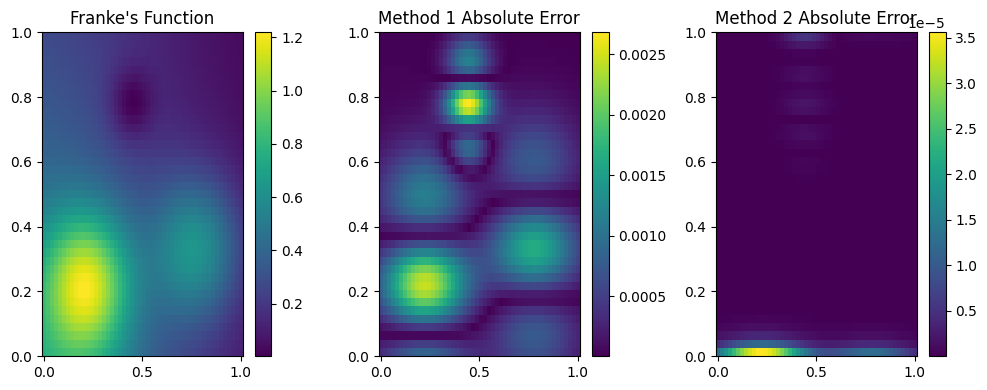

(0.0026831071353539265,
 3.5580763251163994e-05,
 0.9964679138322067,
 3.385684446263023e-06,
 1.811981201171875e-05,
 0.0011968612670898438)

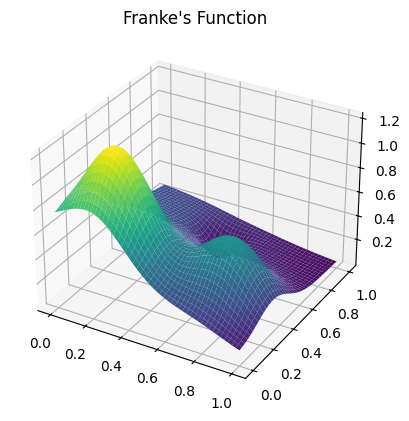

In [690]:
def part2_analyze():
    """
    Add input/output as needed
    """

    #----- Code for generating grid, use/modify/discard as needed ----#
    n,m = 50,40 #arbitrary grid sizes
    x = np.linspace(0,1,n)
    y = np.linspace(0,1,m)
    xg,yg = np.meshgrid(x,y)
    dy = y[1]-y[0]
    yI = y[:-1]+dy/2 #grid for interpolated data
    #--------------------------------------------#

    #add code here
    import time
    #Testing function (Franke's Function)
    def frankes_function(x, y):
        return (0.75 * np.exp(-((9 * x - 2) ** 2) / 4 - (9 * y - 2) ** 2 / 4) 
                + 0.75 * np.exp(-((9 * x + 1) ** 2) / 49 - (9 * y + 1) / 10)
                + 0.5 * np.exp(-((9 * x - 7) ** 2) / 4 - (9 * y - 3) ** 2 / 4)
                - 0.2 * np.exp(-((9 * x - 4) ** 2) - (9 * y - 7) ** 2))

    # Numerical test with method 1
    f = frankes_function(xg, yg)
    t1 = time.time()
    fI1 = part2(f, method=1)
    t2 = time.time()

    # Numerical test with method 2
    fI2 = part2(f, method=2)
    t3 = time.time()

    fI_true = frankes_function(xg[:-1, :], yI[:, None])
    # Plot the results
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Franke's Function")
    plt.pcolormesh(xg[:-1, :], yI, fI_true, shading='auto')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("Method 1 Absolute Error")
    plt.pcolormesh(xg[:-1, :], yI, np.abs(fI1 - fI_true), shading='auto')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title("Method 2 Absolute Error")
    plt.pcolormesh(xg[:-1, :], yI, np.abs(fI2 - fI_true), shading='auto')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(xg, yg, frankes_function(xg, yg), cmap='viridis')
    ax.set_title("Franke's Function")

    return np.max(np.abs(fI1 - fI_true)), np.max(np.abs(fI2 - fI_true)), 1-np.mean(np.abs(fI1 - fI_true)/fI_true), np.mean(np.abs(fI2 - fI_true)/fI_true), t2-t1, t3-t2 #modify as needed


part2_analyze()

In [1110]:
def part3q1(y0,alpha,beta,b,c,tf=200,Nt=800,err=1e-6,method="RK45"):
    """
    Part 3 question 1
    Simulate system of 2n nonlinear ODEs

    Input:
    y0: Initial condition, size 2*n array
    alpha,beta,b,c: model parameters
    tf,Nt: Solutions are computed at Nt time steps from t=0 to t=tf (see code below)

    Output:
    tarray: size Nt+1 array
    yarray: Nt+1 x 2*n array containing y at
            each time step including the initial condition.
    """
    
    #Set up parameters, arrays

    n = y0.size//2
    tarray = np.linspace(0,tf,Nt+1)
    yarray = np.zeros((Nt+1,2*n))
    yarray[0,:] = y0


    def RHS(t,y):
        """
        Compute RHS of model
        """
        #add code here
        u = y[:n];v=y[n:]
        r2 = u**2+v**2
        nu = r2*u
        nv = r2*v
        cu = np.roll(u,1)+np.roll(u,-1)
        cv = np.roll(v,1)+np.roll(v,-1)

        dydt = alpha*y
        dydt[:n] += beta*(cu-b*cv)-nu+c*nv+b*(1-alpha)*v
        dydt[n:] += beta*(cv+b*cu)-nv-c*nu-b*(1-alpha)*u

        return dydt


    sol = solve_ivp(RHS, (tarray[0],tarray[-1]), y0, t_eval=tarray, method=method,atol=err,rtol=err)
    yarray = sol.y.T 
    return tarray,yarray


def part3_analyze(display = False):#add/remove input variables if needed
    """
    Part 3 question 1: Analyze dynamics generated by system of ODEs
    """

    #Set parameters
    beta = (25/np.pi)**2
    alpha = 1-2*beta
    b =-1.5
    n = 4000

    #Set initial conidition
    L = (n-1)/np.sqrt(beta)
    k = 40*np.pi/L
    a0 = np.linspace(0,L,n)
    A0 = np.sqrt(1-k**2)*np.exp(1j*a0)
    y0 = np.zeros(2*n)
    y0[:n]=1+0.2*np.cos(4*k*a0)+0.3*np.sin(7*k*a0)+0.1*A0.real

    #---Example code for computing solution, use/modify/discard as needed---#
    c_vals = [0.5, 1.0, 1.3, 1.4]
    epsilons = np.logspace(-1, 2.5, 100)
    a_vals = np.zeros(4)
    indices = [40, 70]
    frequencies = np.zeros(4)
    var_ratios = np.zeros(4)

    fig1, ax1 = plt.subplots(2, 2)
    fig1.tight_layout(w_pad=4.8, h_pad=3.2)
    fig2, ax2 = plt.subplots(2, 2)
    fig2.tight_layout(w_pad=4.8, h_pad=3.2)
    fig3, ax3 = plt.subplots(2, 2)
    fig3.tight_layout(w_pad=4.8, h_pad=3.2)
    fig4, ax4 = plt.subplots(2, 2)
    fig4.tight_layout(w_pad=4.8, h_pad=3.2)
    fig5, ax5 = plt.subplots(2, 2)
    fig5.tight_layout(w_pad=4.8, h_pad=3.2)
    fig6, ax6 = plt.subplots(2, 2)
    fig6.tight_layout(w_pad=4.8, h_pad=3.2)

    for i, c_val in enumerate(c_vals):
        y0 = np.zeros(2*n)
        y0[:n]=1+0.2*np.cos(4*k*a0)+0.3*np.sin(7*k*a0)+0.1*A0.real
        t,y = part3q1(y0,alpha,beta,b,c_val,tf=20,Nt=2,method='RK45') #for transient, modify tf and other parameters as needed
        y0 = y[-1,:]
        t,y = part3q1(y0,alpha,beta,b,c_val,method='RK45',err=1e-6)
        u,v = y[:,:n],y[:,n:]
        u_clean = u[:, 100:-100]
        n1 = len(u_clean)
        D = sp.spatial.distance.pdist(u_clean)
        C = np.array([D[D < eps].size for eps in epsilons]) * 2/(n1*(n1-1))
        plot = np.unravel_index(i, (2, 2))
        ax1[plot].loglog(epsilons, C, marker='x')
        ax1[plot].set_xlabel('$\epsilon$')
        ax1[plot].set_ylabel('$C(\epsilon)$')
        ax1[plot].set_title(f'log-log plot for c = {c_val}')
        m, c = np.polyfit(np.log(epsilons[indices[0]:indices[1]]), np.log(C[indices[0]:indices[1]]), 1)
        ax1[plot].plot(epsilons, np.exp(c) * epsilons**m, linestyle='dashed', label = f'slope = {"%.2f" % round(m, 2)}')
        ax1[plot].legend(loc = 'upper left')
        a_vals[i] = m

        A = ((u_clean - np.mean(u_clean, axis = 0))/np.std(u_clean, axis = 0)).T
        U, S, WT = np.linalg.svd(A)
        T = U.T
        Anew = np.matmul(T, A)
        plot = np.unravel_index(i, (2, 2))
        explained_variance = S**2 / np.sum(S**2)
        var_ratios[i] = explained_variance[0]
        ax2[plot].plot(np.cumsum(explained_variance), marker = 'o', markersize = 3.0)
        ax2[plot].set_xlabel('Number of PCs')
        ax2[plot].set_ylabel('Cumulative Explained Variance')
        ax2[plot].set_title(f'c = {c_val}')

        ax3[plot].set_xlabel('t')
        ax3[plot].set_title(f'First PC against time')
        ax3[plot].plot(Anew[0, :])

        fB, PxxB = sp.signal.welch(Anew[0, :])
        ax4[plot].set_xlabel('Frequency')
        ax4[plot].set_ylabel('Power Spectral Density')
        ax4[plot].set_title(f"Welch's plot for c = {c_val}")
        ax4[plot].semilogy(fB, PxxB)

        ax5[plot].set_title(f'Contour plot of solution for c = {c_val}')
        ax5[plot].contourf(np.arange(n),t,u,20)

        frequencies[i] = fB[np.argmax(PxxB)]
        dt = t[1]
        tau = 1/(20*frequencies[i])
        Del = int(tau/dt)
        x = Anew[0, :]
        v1 = np.vstack([x[:-2*Del],x[Del:-Del],x[2*Del:]])
        ax6[plot].set_xlabel('$PC1_i$')
        ax6[plot].set_ylabel('$PC1_{i+1}$')
        ax6[plot].set_title(f'Solution recreation for PC1, c = {c_val}')
        ax6[plot].plot(v1[0],v1[1])
        


    #if display:
    #    plt.figure()
    #    plt.contourf(np.arange(n),t,u,20)

    #-------------------------------------------#

    #Add code here

    #plt.plot(np.abs(np.fft.fft(y[:, 100:n-100]))**2)

    return a_vals, frequencies #modify if needed


(array([0.81220343, 1.04508079, 2.07919141, 2.51045434]),
 array([0.01953125, 0.0390625 , 0.046875  , 0.05078125]))

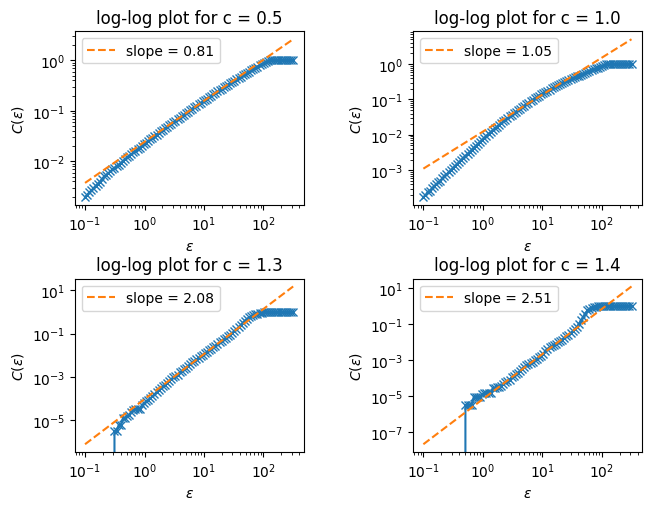

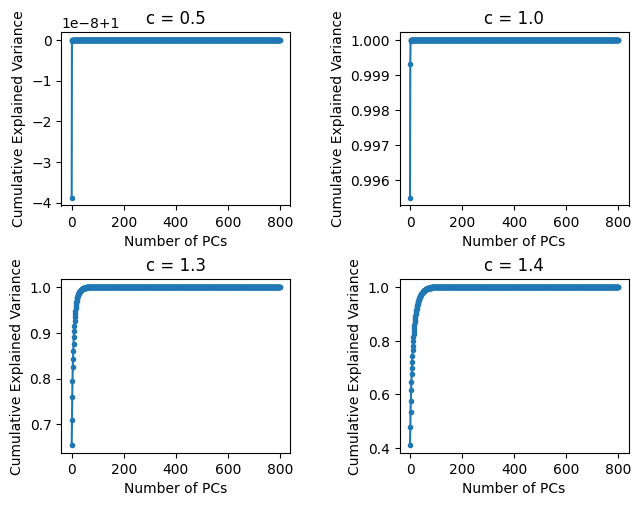

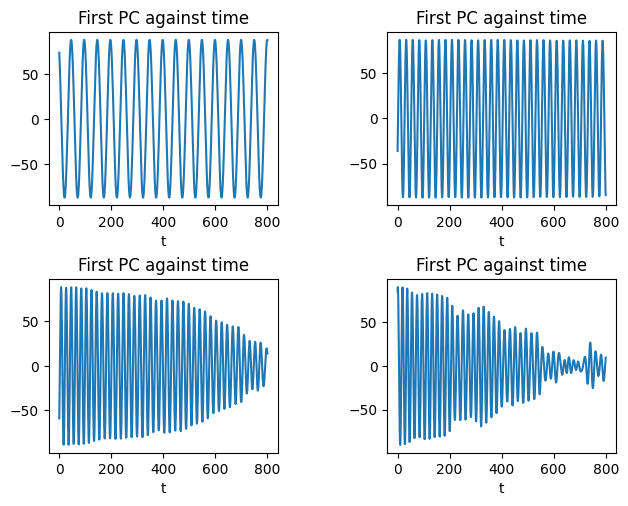

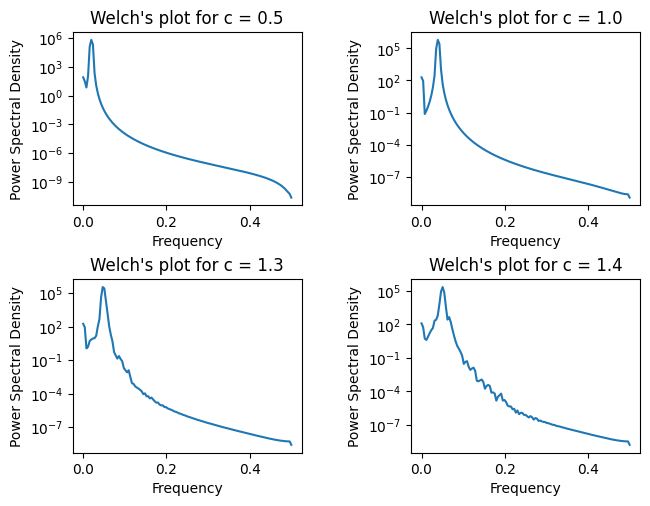

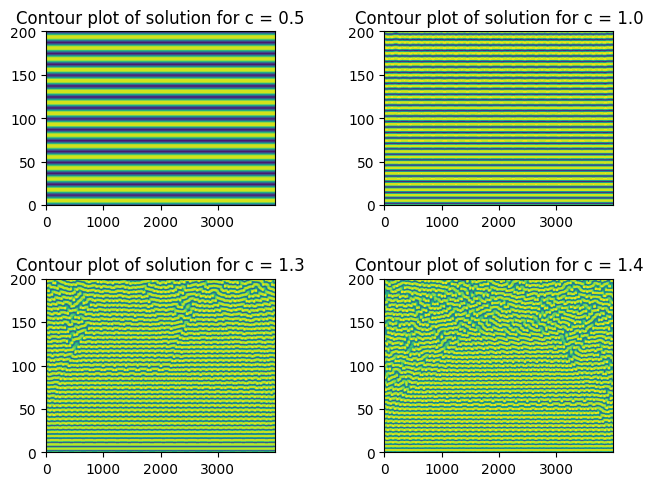

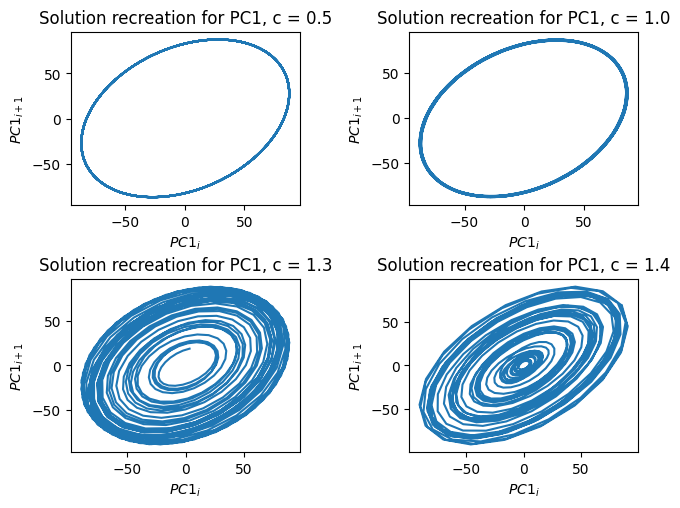

In [1111]:
part3_analyze(display = True)

0.01953125

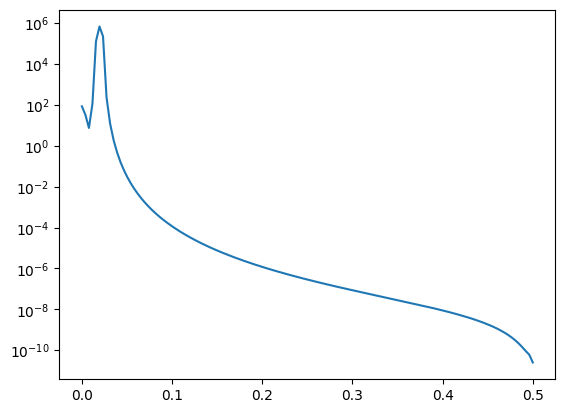

In [1065]:
fB, PxxB = sp.signal.welch(Anew[0, :])
plt.semilogy(fB, PxxB)
fB[np.argmax(PxxB)]

40 801


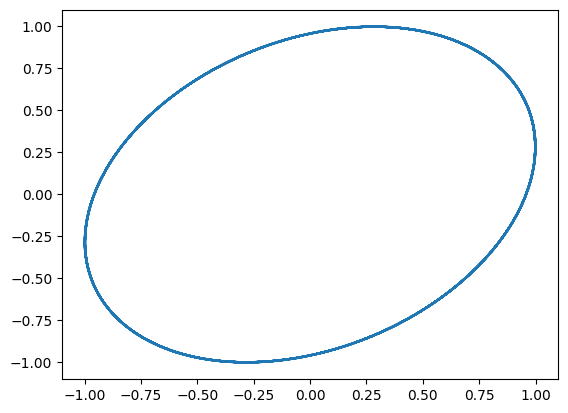

In [1081]:
f = fB[np.argmax(PxxB)]
dt = t[1]
tau = 1/(5*f)
Del = int(tau/dt)
x = u[:, 54]
print(Del,x.size)
v1 = np.vstack([x[:-2*Del],x[Del:-Del],x[2*Del:]])
v1.shape
v10 = v1.copy()
plt.plot(v1[0],v1[1])

10 801


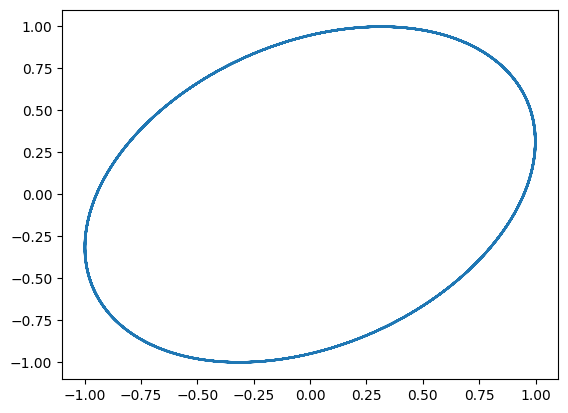

In [1082]:
tau = tau/4
Del = int(tau/dt)
print(Del,x.size)
v1 = np.vstack([x[:-2*Del],x[Del:-Del],x[2*Del:]])
v1.shape
plt.figure()
plt.plot(v1[0], v1[1])

In [1053]:
dt

0.25

In [886]:
def part3q1(y0,alpha,beta,b,c,tf=200,Nt=800,err=1e-6,method="RK45"):
    """
    Part 3 question 1
    Simulate system of 2n nonlinear ODEs

    Input:
    y0: Initial condition, size 2*n array
    alpha,beta,b,c: model parameters
    tf,Nt: Solutions are computed at Nt time steps from t=0 to t=tf (see code below)

    Output:
    tarray: size Nt+1 array
    yarray: Nt+1 x 2*n array containing y at
            each time step including the initial condition.
    """
    
    #Set up parameters, arrays

    n = y0.size//2
    tarray = np.linspace(0,tf,Nt+1)
    yarray = np.zeros((Nt+1,2*n))
    yarray[0,:] = y0


    def RHS(t,y):
        """
        Compute RHS of model
        """
        #add code here
        u = y[:n];v=y[n:]
        r2 = u**2+v**2
        nu = r2*u
        nv = r2*v
        cu = np.roll(u,1)+np.roll(u,-1)
        cv = np.roll(v,1)+np.roll(v,-1)

        dydt = alpha*y
        dydt[:n] += beta*(cu-b*cv)-nu+c*nv+b*(1-alpha)*v
        dydt[n:] += beta*(cv+b*cu)-nv-c*nu-b*(1-alpha)*u

        return dydt


    sol = solve_ivp(RHS, (tarray[0],tarray[-1]), y0, t_eval=tarray, method=method,atol=err,rtol=err)
    yarray = sol.y.T 
    return tarray,yarray

def part3q2(x,c=1.0):
    """
    Code for part 3, question 2
    """
    #Set parameters
    beta = (25/np.pi)**2
    alpha = 1-2*beta
    b =-1.5
    n = 4000

    #Set initial conidition
    y0 = np.zeros(2*n)
    L = (n-1)/np.sqrt(beta)
    k = 40*np.pi/L
    a0 = np.linspace(0,L,n)
    A0 = np.sqrt(1-k**2)*np.exp(1j*a0)
    y0[:n]=1+0.2*np.cos(4*k*a0)+0.3*np.sin(7*k*a0)+0.1*A0.real

    #Compute solution
    t,y = part3q1(y0,alpha,beta,b,c,tf=20,Nt=2,method='RK45') #for transient, modify tf and other parameters as needed
    y0 = y[-1,:]
    t,y = part3q1(y0,alpha,beta,b,c,method='RK45',err=1e-6)
    A = y[:,:n]

    #Analyze code here
    l1,v1 = np.linalg.eigh(A.T.dot(A))
    v2 = A.dot(v1)
    A2 = (v2[:,:x]).dot((v1[:,:x]).T)
    e = np.sum((A2.real-A)**2)

    return A2.real,e, np.shape(A)
part3q2(3)

(array([[-3.71268553e-07, -4.96691789e-07, -7.58211104e-09, ...,
          4.87177896e-08,  3.67637893e-08,  3.88528286e-08],
        [-5.12952690e-08, -3.03499251e-07, -1.52754409e-08, ...,
          2.32506257e-08,  1.16837052e-08,  1.71293689e-08],
        [ 3.18567864e-07, -2.64042985e-08, -2.06233107e-08, ...,
         -1.00199007e-08, -1.82226534e-08, -1.07780714e-08],
        ...,
        [ 2.31341710e-07, -2.04849436e-08, -1.67900857e-08, ...,
         -6.88232248e-09, -1.67976146e-08, -7.13426474e-09],
        [-1.14930801e-06,  2.93292914e-07,  9.12020051e-08, ...,
          2.13846710e-08,  7.01469887e-08,  2.72313561e-08],
        [-1.81147826e-07, -1.87417141e-07,  4.55149352e-11, ...,
          1.98342682e-08,  1.72605674e-08,  1.60554247e-08]]),
 1596419.2408995994,
 (801, 4000))

In [301]:
def part3q1(y0,alpha,beta,b,c,tf=200,Nt=800,err=1e-6,method="RK45"):
    """
    Part 3 question 1
    Simulate system of 2n nonlinear ODEs

    Input:
    y0: Initial condition, size 2*n array
    alpha,beta,b,c: model parameters
    tf,Nt: Solutions are computed at Nt time steps from t=0 to t=tf (see code below)

    Output:
    tarray: size Nt+1 array
    yarray: Nt+1 x 2*n array containing y at
            each time step including the initial condition.
    """
    
    #Set up parameters, arrays

    n = y0.size//2
    tarray = np.linspace(0,tf,Nt+1)
    yarray = np.zeros((Nt+1,2*n))
    yarray[0,:] = y0


    def RHS(t,y):
        """
        Compute RHS of model
        """
        #add code here
        u = y[:n];v=y[n:]
        r2 = u**2+v**2
        nu = r2*u
        nv = r2*v
        cu = np.roll(u,1)+np.roll(u,-1)
        cv = np.roll(v,1)+np.roll(v,-1)

        dydt = alpha*y
        dydt[:n] += beta*(cu-b*cv)-nu+c*nv+b*(1-alpha)*v
        dydt[n:] += beta*(cv+b*cu)-nv-c*nu-b*(1-alpha)*u

        return dydt


    sol = solve_ivp(RHS, (tarray[0],tarray[-1]), y0, t_eval=tarray, method=method,atol=err,rtol=err)
    yarray = sol.y.T 
    return tarray,yarray

In [121]:
def part3q2(x,c=1.0):
    """
    Code for part 3, question 2
    """
    #Set parameters
    beta = (25/np.pi)**2
    alpha = 1-2*beta
    b =-1.5
    n = 4000

    #Set initial conidition
    y0 = np.zeros(2*n) #I EDITTED THIS CHECK IT MATE
    L = (n-1)/np.sqrt(beta)
    k = 40*np.pi/L
    a0 = np.linspace(0,L,n)
    A0 = np.sqrt(1-k**2)*np.exp(1j*a0)
    y0[:n]=1+0.2*np.cos(4*k*a0)+0.3*np.sin(7*k*a0)+0.1*A0.real

    #Compute solution
    t,y = part3q1(y0,alpha,beta,b,c,tf=20,Nt=2,method='RK45') #for transient, modify tf and other parameters as needed
    y0 = y[-1,:]
    t,y = part3q1(y0,alpha,beta,b,c,method='RK45',err=1e-6)
    A = y[:,:n]

    #Analyze code here
    l1,v1 = np.linalg.eigh(A.T.dot(A))
    v2 = A.dot(v1)
    A2 = (v2[:,:x]).dot((v1[:,:x]).T)
    e = np.sum((A2.real-A)**2)

    return A2,e,A

In [141]:
A2, errors, A = part3q2(99)

In [123]:
U, S, WT = np.linalg.svd(A)
S

array([1.26027598e+03, 8.29483962e+01, 3.44244737e+01, 6.53116420e+00,
       2.98764275e+00, 2.17442674e+00, 1.16027249e+00, 5.57881164e-01,
       3.90430644e-01, 2.26482098e-01, 1.28466161e-01, 8.99559640e-02,
       6.10214030e-02, 4.68976247e-02, 3.37833620e-02, 1.74289631e-02,
       1.07786472e-02, 7.81768368e-03, 4.64867925e-03, 2.05113316e-03,
       1.31059701e-03, 1.28562047e-03, 8.83261653e-04, 6.86465097e-04,
       3.91574226e-04, 3.58651041e-04, 2.89262002e-04, 1.87616927e-04,
       1.56515227e-04, 1.36099711e-04, 9.70859414e-05, 9.03244999e-05,
       6.55396029e-05, 5.56213819e-05, 4.90190730e-05, 3.75704299e-05,
       3.02226177e-05, 1.81241897e-05, 1.76652857e-05, 1.45310523e-05,
       1.21305084e-05, 9.77077111e-06, 7.80058097e-06, 4.80323552e-06,
       4.50694165e-06, 3.40032128e-06, 3.15796306e-06, 2.33628441e-06,
       1.96412203e-06, 1.72089021e-06, 1.51538027e-06, 1.28585736e-06,
       1.03815298e-06, 9.28481178e-07, 8.02592115e-07, 5.49985677e-07,
      

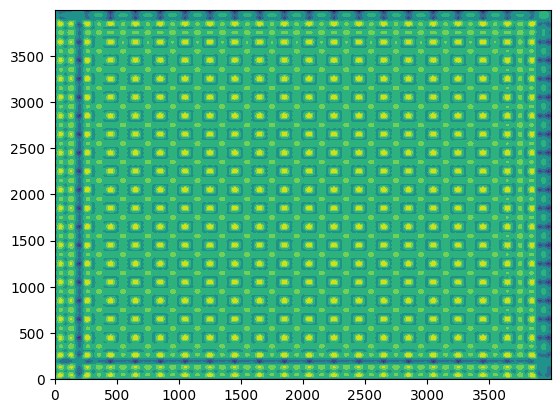

In [142]:
plt.contourf(A.T.dot(A))

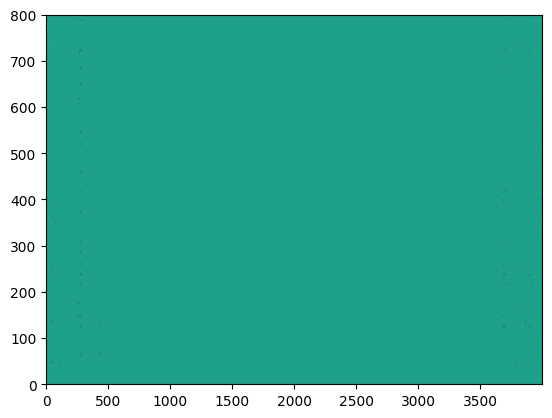

In [145]:
plt.contourf(A2)

In [115]:
np.linalg.matrix_rank(A)

99

In [116]:
np.linalg.matrix_rank(A2)

10

In [128]:
np.max(A2)

2.1271243191129745e-06

In [146]:
A.T.dot(A)

array([[394.70170268, 394.76583736, 394.82850711, ..., 394.50763356,
        394.57208576, 394.63708442],
       [394.76583736, 394.83823756, 394.9093979 , ..., 394.54842367,
        394.62040698, 394.69319023],
       [394.82850711, 394.9093979 , 394.98929104, ..., 394.58717584,
        394.66686429, 394.74762308],
       ...,
       [394.50763356, 394.54842367, 394.58717584, ..., 394.37985862,
        394.42286147, 394.46575294],
       [394.57208576, 394.62040698, 394.66686429, ..., 394.42286147,
        394.47281495, 394.52285922],
       [394.63708442, 394.69319023, 394.74762308, ..., 394.46575294,
        394.52285922, 394.58027564]])